In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 遼寧資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-遼寧1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-遼寧2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-遼寧3.xls')
df4 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-遼寧4.xls')
patent_df = pd.concat([df1,df2,df3,df4],ignore_index=True,sort=True)

In [3]:
patent_df.shape

(201281, 38)

In [4]:
patent_df['申请人地址'].fillna('',inplace=True)
patent_df = patent_df[patent_df['申请人地址']!='']

In [5]:
patent_df.shape

(201281, 38)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'21\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [8]:
patent_df_firm.shape

(6001, 38)

In [9]:
firm_gd.shape

(16038, 6)

In [10]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [11]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\遼寧_廠商.xlsx')

# 非模糊比對

In [12]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(1663, 45)
(20376, 45)


In [13]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(6498, 50)
(14335, 50)


D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [14]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\遼寧_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(797, 44)
(17872, 44)
(4651, 49)
(17872, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\遼寧_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', 'CPC', 'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）',
       '专利类型', '中国申请人区县', '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日',
       '发明人', '合享价值度', '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数',
       '文献页数', '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码',
       '申请人类型', '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)',
       '被引证次数', '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '沈陽',
       '大連', '鞍山', '營口', '遼陽', '本溪', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','沈陽','大連','鞍山','營口','遼陽','本溪','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(6468, 58)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\遼寧_結果.xlsx')

# 模糊比對

In [15]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(1881, 45)
(20035, 45)


In [16]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(6381, 50)
(14094, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\遼寧_模糊結果.xlsx')

# 定位

In [6]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\遼寧_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\遼寧_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(6468, 58)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(17872, 58)
(152, 58)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\遼寧_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
伟                   1
赵富增                  1
李宏财                  1
李宏超                  1
李宏轮                  1
                  ... 
中国科学院金属研究所        2213
东北大学              2435
中国科学院大连化学物理研究所    3356
鞍钢股份有限公司          3446
大连理工大学            3838
Name: 專利數, Length: 68985, dtype: int64

In [7]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\遼寧_結果.xlsx',index_col=0)
target1 = (41.71674,123.45845)
merge_df['沈陽'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (38.86539,121.51582)
merge_df['大連'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (41.10971,123.04815)
merge_df['鞍山'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (40.65471,122.19234)
merge_df['營口'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
target5 = (41.23143,123.19054)
merge_df['遼陽'] = merge_df.apply(lambda x:how_far(target5,(x['lat'],x['lnt'])),axis=1)
target6 = (41.47667,123.70958)
merge_df['本溪'] = merge_df.apply(lambda x:how_far(target6,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\遼寧_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (41.71674,123.45845)
target2 = (38.86539,121.51582)
target3 = (41.10971,123.04815)
target4 = (40.65471,122.19234)
target5 = (41.23143,123.19054)
target6 = (41.47667,123.70958)

for i in merge_df[merge_df['沈陽']==''].index:
    merge_df.loc[i,'沈陽'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'大連'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'鞍山'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'營口'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'遼陽'] = how_far(target5,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'本溪'] = how_far(target6,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['沈陽']<10)or(x['大連']<10)or(x['鞍山']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['營口']<10)or(x['遼陽']<10)or(x['本溪']<10)) else 0,axis=1)

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\遼寧_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(17872, 58)
0.7807184422560429
0.0034131602506714412


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       13953
1.0        1038
2.0         541
3.0         327
4.0         220
5.0         175
6.0         197
7.0         142
8.0         149
9.0          99
10.0         90
11.0         70
12.0         66
13.0         65
14.0         60
15.0         49
16.0         45
17.0         43
18.0         38
19.0         36
20.0         31
21.0         21
22.0         24
23.0         16
24.0         23
25.0         20
26.0         13
27.0          6
28.0         13
29.0         17
30.0          8
31.0         10
32.0         14
33.0          9
34.0         10
35.0          7
36.0          7
37.0          9
38.0         11
39.0         11
40.0          2
41.0          4
42.0          4
43.0          8
44.0          8
45.0          5
46.0          2
47.0          4
48.0          4
49.0          2
50.0          1
51.0          7
53.0          1
54.0          1
55.0          3
56.0          2
57.0          3
58.0          3
59.0          2
60.0          3
61.0          2
62.0          1
63.0

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0      118
1.0       15
2.0        5
3.0        2
4.0        3
5.0        3
7.0        1
9.0        1
10.0       2
60.0       1
115.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

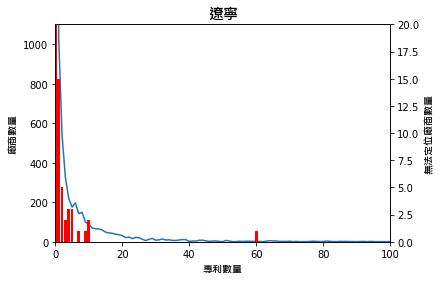

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('遼寧',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,1100])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\遼寧_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

1720
0.09769396796546632
30


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1       507
2       287
3       157
4       113
5        64
6        68
7        51
8        54
9        39
10       31
11       20
12       19
13       19
14       26
15       14
16       16
17       17
18       11
19       16
20       12
21        7
22       10
23        3
24        8
25        8
26        4
27        2
28        5
29        7
30        3
31        2
32        5
33        2
34        4
35        1
36        3
37        6
38        6
39        5
40        1
41        1
42        1
43        3
44        4
45        1
46        1
47        1
49        1
50        1
51        2
53        1
54        1
55        2
56        1
57        2
58        2
59        2
60        1
61        1
63        2
64        2
65        2
66        3
67        2
68        1
69        1
70        2
72        1
74        1
75        1
76        1
81        2
85        1
87        1
88        1
90        1
92        2
94        1
103       1
107       1
108       1
112       1
114       1


In [4]:
not_merge[not_merge['專利數']>=500].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,沈陽,大連,鞍山,營口,遼陽,本溪,早期園區,近期園區,專利數,name_clean
17594,,,,,,,,C04B2/10; C04B35/66,CN102976640B; CN102976640A,2,,发明授权,[甘井子],[大连],,CN,CN102976640B,2014-08-13 00:00:00,吴占德; 柏杉; 洪艳萍; 白城,9,CN,,31095,CN102659436A; CN102285806A,"<text>吴俊银.二步煅烧法合成镁钙砂的研究.《甘肃冶金》.2007, 第29卷(第6期), 第20-22页.</text><text>代小伟等.选用优质白云石试制镁钙合成砂.《河北冶金》.2006, 第72-73页.</text>",...,企业,CN201210552151.9,2012-12-18 00:00:00,CN102976640B; CN102976640A,2,,,0,到incoPat中查看\r\nCN102976640B,中冶焦耐工程技术有限公司,中冶焦耐工程技术有限公司,辽宁省大连市高新技术产业园区七贤岭高能街128号,1,38.8583,121.528,357.318549,1.311885,281.686372,207.424194,299.260319,345.034084,1,0,528,中冶焦耐工程技术
17652,,,,,,,,F24F7/00,CN103017286A; CN103017286B,2,,发明授权,[铁西],[沈阳],,CN,CN103017286B,2015-03-25 00:00:00,牟永来; 刘刃; 陈伟庭,9,CN,,20039,CN203083067U; JP2003185186A; JP2011133160A; CN201028727Y; CN200979264Y; CN102705947A; CN201582936U,,...,企业,CN201210584479.9,2012-12-31 00:00:00,CN103017286B; CN103017286A,2,,,0,到incoPat中查看\r\nCN103017286B,沈阳远大铝业工程有限公司,沈阳远大铝业工程有限公司,辽宁省沈阳市经济技术开发区十三号街20号,1,41.7448,123.228,19.385750,351.297001,72.123650,149.024009,57.101152,49.948340,0,0,757,沈阳远大铝业工程
16283,,,,,,,,C22C29/08,CN1292087C; CN1584092A,2,,发明授权,[大东],[沈阳],CN03134123 20030820,CN,CN1292087C,2006-12-27 00:00:00,方波; 孙海; 穆昆同; 于月光; 曾克里,8,CN,,18728,,,...,企业,CN03134123.3,2003-08-20 00:00:00,CN1292087C; CN1584092A,2,,,0,到incoPat中查看\r\nCN1292087C,沈阳黎明航空发动机(集团)有限责任公司,沈阳黎明航空发动机(集团)有限责任公司,辽宁省沈阳市大东区东塔街六号,1,41.7998,123.506,10.040013,367.091565,85.663827,168.243706,68.400327,39.681846,0,0,1160,沈阳黎明航空发动机
17596,,,,,,,,B02C2/00; B02C23/02,CN102989546A; CN102989546B,2,,发明授权,[铁东],[鞍山],,CN,CN102989546B,2014-11-05 00:00:00,傅国辉; 许广明; 许玲; 徐冬林; 何显明,9,CN,,27095,CN203044066U; CN202343237U; CN201493157U,,...,企业,CN201210550690.9,2012-12-18 00:00:00,CN102989546A; CN102989546B,2,,,0,到incoPat中查看\r\nCN102989546B,鞍钢集团矿业公司,鞍钢集团矿业公司,辽宁省鞍山市铁东区二一九路39号,1,41.1074,122.999,77.805484,279.317060,4.112243,84.575825,21.150664,72.261165,1,0,1266,鞍钢矿业
17615,,,,,,,,C22C38/38; C22C38/26; C21D8/02,CN103882320A; CN103882320B,2,,发明授权,[铁西],[鞍山],,CN,CN103882320B,2016-09-07 00:00:00,王科强; 刘仁东; 王旭; 郭金宇; 林利; 徐荣杰; 孙建伦; 徐鑫; 张宇; 吕冬,9,CN,,5812,JP2005256044A; JP2009013478A; JP2011140688A; JP2011144414A,,...,企业,CN201210560597.6,2012-12-21 00:00:00,CN103882320B; CN103882320A,2,,,0,到incoPat中查看\r\nCN103882320B,鞍钢股份有限公司,鞍钢股份有限公司,辽宁省鞍山市铁西区鞍钢厂区内,0,41.1139,122.978,78.056393,279.159466,5.871169,83.607966,22.069056,73.300915,1,0,3446,鞍钢


Text(0.5, 0, '專利數量')

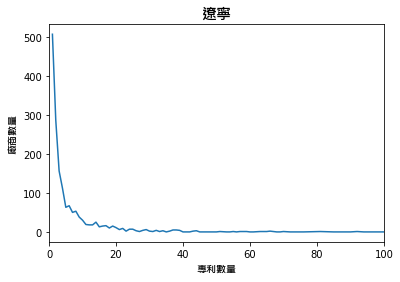

In [6]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('遼寧',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [5]:
cleaned.to_excel(r'E:\paper\名稱merge\遼寧_結果.xlsx')

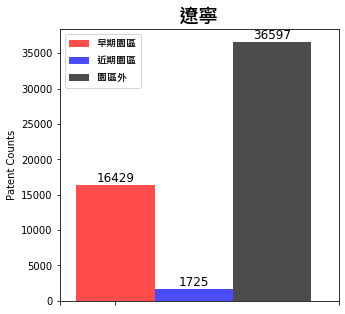

In [11]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('遼寧',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

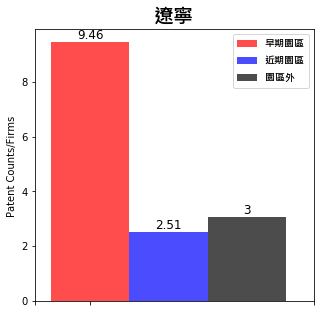

In [12]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('遼寧',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)